# Importing Libraries


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn.metrics import classification_report, confusion_matrix
plt.style.use('fivethirtyeight') 

# Data Loading and Preprocessing

In [2]:
df  = pd.read_csv("Crypto_Data.csv")
df.head()

,Cryptogram,Label
0,JHZUYYH OL H LDHP LRLDUT CB BCAP LDHPL OE DSU ...,0
1,DSU HFU CB PUHLCE KUOEF HE OEVULDOFHDOCE CB DP...,0
2,DSU TCLD OTZCPDHED ZCLODOCE DSHD AEODUX DSU UH...,0
3,MECIE EUCL OEJYAXU TCPU DSHE LUVUEDUUE DSCALHE...,0
4,ISUE H EUC OL XUDUJDUX YOMU HYY CDSUP LTHYY LC...,0


In [3]:
# Label 0 : Simple Substitution
# Label 1 : Vignere
label = np.array(df.Label)
label = label.reshape([100, 1])
cv = CountVectorizer(max_features=500)
train = cv.fit_transform(df.Cryptogram).toarray()


In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(train, label, test_size = 0.1)
X_train = X_train.T
Y_train = Y_train.T
X_val = X_val.T
Y_val = Y_val.T
#Shape format : 
#For x: (No. of features, No. of samples)
#For y: (Label, No. of samples)
print("Shape of training features: ", X_train.shape)
print("Shape pf training labels: ", Y_train.shape)
print("Shape of validation features: ", X_val.shape)
print("Shape of validation labels: ", Y_val.shape)

Shape of training features:  (500, 90)
Shape pf training labels:  (1, 90)
Shape of validation features:  (500, 10)
Shape of validation labels:  (1, 10)


# Creating Model

### Initializing parameters:

In [5]:
def shape_of_parameters(W1_shape, b1_shape, W2_shape, b2_shape, W3_shape, b3_shape):
    parameters_shape = {}
    parameters_shape["W1_shape"] = W1_shape
    parameters_shape["b1_shape"] = b1_shape
    parameters_shape["W2_shape"] = W2_shape
    parameters_shape["b2_shape"] = b2_shape
    parameters_shape["W3_shape"] = W3_shape
    parameters_shape["b3_shape"] = b3_shape
    return parameters_shape   

In [6]:
def initialize_parameters(W1_shape, b1_shape, W2_shape, b2_shape, W3_shape, b3_shape):
    W1 = tf.get_variable("W1", shape = W1_shape, initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", shape = b1_shape, initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", shape = W2_shape, initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", shape = b2_shape, initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", shape = W3_shape, initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", shape = b3_shape, initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3
                 }
    return parameters   

###  One step of Forward propagation:

In [7]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                           
    A1 = tf.nn.relu(Z1)                                              
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                          
    A2 = tf.nn.relu(Z2)                                         
    Z3 = tf.add(tf.matmul(W3, A2), b3)   
    return Z3

### Computing cross-entropy loss:

In [8]:
costs = {}     #Dictionary of costs for all the three models
def compute_cost(Z3, Y, parameters):

    # to fit the tensorflow requirement for tf.nn.sigmoid_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost

## Defining Model:

In [9]:
def model(parameters_shape, X_train, Y_train, learning_rate = 0.001, num_epochs = 50):
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    X = tf.placeholder(tf.float32, [500, None])
    Y = tf.placeholder(tf.float32, [1, None])
    (n_x, m) = X_train.shape                    
    n_y = 1                                          #either 0 or 1
    model_cost = []
    #Initializing parameters
    W1_shape = parameters_shape["W1_shape"]
    b1_shape = parameters_shape["b1_shape"]
    W2_shape = parameters_shape["W2_shape"]
    b2_shape = parameters_shape["b2_shape"]
    W3_shape = parameters_shape["W3_shape"]
    b3_shape = parameters_shape["b3_shape"]
    parameters = initialize_parameters(W1_shape, b1_shape, W2_shape, b2_shape, W3_shape, b3_shape)
    
    
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y, parameters)
    #Backpropagation:
    optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            model_cost.append(epoch_cost)

            # Print the cost every 5th epoch
            if(epoch%5 == 0):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))

        #save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        return model_cost, parameters

In [10]:
parameters_shape = shape_of_parameters((128, 500), (128, 1), (64, 128), (64, 1), (1, 64), (1, 1))
model_cost, parameters = model(parameters_shape, X_train, Y_train)
costs["model1"] = model_cost

Cost after epoch 0: 0.739604
Cost after epoch 5: 0.537911
Cost after epoch 10: 0.388072
Cost after epoch 15: 0.262833
Cost after epoch 20: 0.162931
Cost after epoch 25: 0.091631
Cost after epoch 30: 0.047283
Cost after epoch 35: 0.023705
Cost after epoch 40: 0.012425
Cost after epoch 45: 0.007102
Parameters have been trained!


# Predicting the labels

### Utility functions for prediction:

In [11]:
def  forward_propagation_for_predict(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1, X), b1)                                           
    A1 = tf.nn.relu(Z1)                                              
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                          
    A2 = tf.nn.relu(Z2)                                         
    Z3 = tf.add(tf.matmul(W3, A2), b3)   
    return Z3

def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3
             }
    x = tf.placeholder("float", [500, None])
    Z3 = forward_propagation_for_predict(x, params)
    p = tf.round(tf.sigmoid(Z3))
    sess = tf.Session()
    predictions = sess.run(p, feed_dict = {x: X})
    return predictions

def print_prediction(predictions, label, data_type): 
    predictions = np.squeeze(predictions)
    for i in range(len(predictions)):
        print("Predicted value: {}, Actual value: {}".format(predictions[i], label[i]))
    accuracy = np.mean(np.equal(predictions, label))
    print("Accuracy on {} set: {}".format(data_type, accuracy))
    

## Accuracy on training set:

In [12]:
predictions = predict(X_train, parameters)
predictions = np.squeeze(predictions)
accuracy = np.mean(np.equal(predictions, Y_train))
print("Accuracy on training set:", accuracy)

Accuracy on training set: 1.0


## Predictions and Accuracy on validation set:

In [13]:
predictions = predict(X_val, parameters)
Y_val = np.squeeze(Y_val)
print_prediction(predictions, Y_val, 'Validation')

Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 1.0, Actual value: 1
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 1.0, Actual value: 1
Predicted value: 0.0, Actual value: 0
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Accuracy on Validation set: 1.0


## Loading and Preprocessing Test set:

In [14]:
df_test = pd.read_csv("Crypto_Test.csv")
df_test.head()
test = cv.transform(df_test.Cryptogram).toarray().T
test_target = df_test.Label
print("Number of test examples : ", test.shape[1])

Number of test examples :  20


## Predictions and Accuracy on Test set:

In [15]:
predictions = predict(test, parameters)
print_prediction(predictions, test_target, 'Test')


Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 0.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 1.0, Actual value: 1
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Predicted value: 0.0, Actual value: 0
Accuracy on Test set: 0.95


## Classification report on Test Set:

In [16]:
predictions = np.squeeze(predictions)
map(int, predictions)
print("Classification report: ")
print(classification_report(test_target, predictions))
print("Confusion matrix: ")
print(confusion_matrix(test_target, predictions))

Classification report: 
             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       1.00      0.90      0.95        10

avg / total       0.95      0.95      0.95        20

Confusion matrix: 
[[10  0]
 [ 1  9]]


# Plotting performance of our model by varying parameters

### Model 2:

In [20]:
parameters_shape = shape_of_parameters((64, 500), (64, 1), (16, 64), (16, 1), (1, 16), (1, 1))
model_cost, parameters = model(parameters_shape, X_train, Y_train)
costs["model2"] = model_cost

Cost after epoch 0: 0.655646
Cost after epoch 5: 0.524394
Cost after epoch 10: 0.424443
Cost after epoch 15: 0.348250
Cost after epoch 20: 0.283539
Cost after epoch 25: 0.226971
Cost after epoch 30: 0.176622
Cost after epoch 35: 0.130652
Cost after epoch 40: 0.091242
Cost after epoch 45: 0.060803
Parameters have been trained!


### Model 3:

In [21]:
parameters_shape = shape_of_parameters((32, 500), (32, 1), (16, 32), (16,1), (1, 16), (1, 1))
model_cost, parameters = model(parameters_shape, X_train, Y_train)
costs["model3"] = model_cost

Cost after epoch 0: 0.715769
Cost after epoch 5: 0.588841
Cost after epoch 10: 0.492054
Cost after epoch 15: 0.413185
Cost after epoch 20: 0.340801
Cost after epoch 25: 0.274452
Cost after epoch 30: 0.213763
Cost after epoch 35: 0.160732
Cost after epoch 40: 0.116104
Cost after epoch 45: 0.082088
Parameters have been trained!


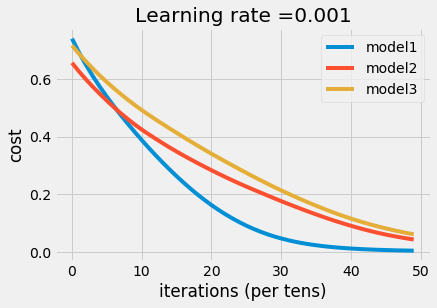

In [23]:
 # plot the cost
plt.plot(np.squeeze(costs["model1"]))
plt.plot(np.squeeze(costs["model2"]))
plt.plot(np.squeeze(costs["model3"]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(0.001))
plt.legend(["model1", "model2", "model3"])
plt.show()